In [69]:
import os
import pickle
import numpy as np
import pandas as pd
import requests
import pyvo as vo
import torch
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from tqdm import tqdm
from astropy.io import fits
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
import torch.nn as nn
from mambapy.mamba import Mamba, MambaConfig
from concurrent.futures import ThreadPoolExecutor, as_completed
import seaborn as sns
from torch.utils.data import Dataset, DataLoader


In [70]:
# Define ADQL query to fetch source IDs of eclipsing binaries
query = """
SELECT source_id
FROM gaiadr3.vari_eclipsing_binary
"""

# Run the query asynchronously
job = Gaia.launch_job_async(query)
results = job.get_results()

# Convert to Pandas DataFrame
df = results.to_pandas()

# Save the Gaia IDs to a pickle file
df.to_pickle("gaia_eclipsing_binaries.pkl")

print(f"✅ Retrieved {len(df)} eclipsing binary sources from Gaia DR3.")
print(df.head())  # Display first few rows


INFO: Query finished. [astroquery.utils.tap.core]
✅ Retrieved 2184477 eclipsing binary sources from Gaia DR3.
         source_id
0   46626164993792
1  104487964717440
2  138577120584320
3  160219460292352
4  203551385701760


In [71]:
#df = df.head(1000)  # Limit to 1000 sources for demonstration purposes

In [72]:
class StarClassifierFusion(nn.Module):
    def __init__(
        self,
        d_model_spectra,
        d_model_gaia,
        input_dim_spectra,
        input_dim_gaia,
        num_classes=55,
        n_layers=6,
        use_cross_attention=False,
        n_cross_attn_heads=8
    ):
        """
        Args:
            d_model_spectra (int): embedding dimension for the spectra MAMBA
            d_model_gaia (int): embedding dimension for the gaia MAMBA
            num_classes (int): multi-label classification
            input_dim_spectra (int): # of features for spectra
            input_dim_gaia (int): # of features for gaia
            n_layers (int): depth for each MAMBA
            use_cross_attention (bool): whether to use cross-attention
            n_cross_attn_heads (int): number of heads for cross-attention
        """
        super().__init__()
        
        # --- MAMBA for spectra ---
        config_spectra = MambaConfig(
            d_model=d_model_spectra,
            d_state=64,
            d_conv=4,
            n_layers=n_layers,
        )
        self.mamba_spectra = Mamba(config_spectra)
        self.input_proj_spectra = nn.Linear(input_dim_spectra, d_model_spectra)

        # --- MAMBA for gaia ---
        config_gaia = MambaConfig(
            d_model=d_model_gaia,
            d_state=64,
            d_conv=4,
            n_layers=n_layers
        )
        self.mamba_gaia = Mamba(config_gaia)
        self.input_proj_gaia = nn.Linear(input_dim_gaia, d_model_gaia)

        # --- Cross Attention (Optional) ---
        self.use_cross_attention = use_cross_attention
        if use_cross_attention:
            # We'll do cross-attn in both directions or just one—here is an example with 2 blocks
            self.cross_attn_block_spectra = CrossAttentionBlock(d_model_spectra, n_heads=n_cross_attn_heads)
            self.cross_attn_block_gaia = CrossAttentionBlock(d_model_gaia, n_heads=n_cross_attn_heads)

        # --- Final Classifier ---
        # If you do late fusion by concatenation, the dimension is d_model_spectra + d_model_gaia
        # If you do average fusion, it is max(d_model_spectra, d_model_gaia) (or keep them separate).
        fusion_dim = d_model_spectra + d_model_gaia
        self.classifier = nn.Sequential(
            nn.LayerNorm(fusion_dim),
            nn.Linear(fusion_dim, num_classes)
        )
    
    def forward(self, x_spectra, x_gaia):
        """
        x_spectra : (batch_size, input_dim_spectra) or potentially (batch_size, seq_len_spectra, input_dim_spectra)
        x_gaia    : (batch_size, input_dim_gaia) or (batch_size, seq_len_gaia, input_dim_gaia)
        """
        # For MAMBA, we expect shape: (B, seq_len, d_model). 
        # If your input is just (B, d_in), we turn it into (B, 1, d_in).
        
        # --- Project to d_model and add sequence dimension (seq_len=1) ---
        x_spectra = self.input_proj_spectra(x_spectra)  # (B, d_model_spectra)
        x_spectra = x_spectra.unsqueeze(1)             # (B, 1, d_model_spectra)

        x_gaia = self.input_proj_gaia(x_gaia)          # (B, d_model_gaia)
        x_gaia = x_gaia.unsqueeze(1)                   # (B, 1, d_model_gaia)

        # --- MAMBA encoding (each modality separately) ---
        x_spectra = self.mamba_spectra(x_spectra)  # (B, 1, d_model_spectra)
        x_gaia = self.mamba_gaia(x_gaia)          # (B, 1, d_model_gaia)

        # Optionally, use cross-attention to fuse the representations
        if self.use_cross_attention:
            # Cross-attention from spectra -> gaia
            x_spectra_fused = self.cross_attn_block_spectra(x_spectra, x_gaia)
            # Cross-attention from gaia -> spectra
            x_gaia_fused = self.cross_attn_block_gaia(x_gaia, x_spectra)
            
            # Update x_spectra and x_gaia
            x_spectra = x_spectra_fused
            x_gaia = x_gaia_fused
        
        # --- Pool across sequence dimension (since our seq_len=1, just squeeze) ---
        x_spectra = x_spectra.mean(dim=1)  # (B, d_model_spectra)
        x_gaia = x_gaia.mean(dim=1)        # (B, d_model_gaia)

        # --- Late Fusion by Concatenation ---
        x_fused = torch.cat([x_spectra, x_gaia], dim=-1)  # (B, d_model_spectra + d_model_gaia)

        # --- Final classification ---
        logits = self.classifier(x_fused)  # (B, num_classes)
        return logits
class CrossAttentionBlock(nn.Module):
    """
    A simple cross-attention block with a feed-forward sub-layer.
    """
    def __init__(self, d_model, n_heads=8):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d_model, 
            num_heads=n_heads, 
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(d_model)
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x_q, x_kv):
        """
        Args:
            x_q  : (batch_size, seq_len_q, d_model)
            x_kv : (batch_size, seq_len_kv, d_model)
        """
        # Cross-attention
        attn_output, _ = self.cross_attn(query=x_q, key=x_kv, value=x_kv)
        x = self.norm1(x_q + attn_output)

        # Feed forward
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x


In [73]:
#--------------------------------------------------------------------------------
# 1) LOAD ALL NECESSARY PRE-FITTED TRANSFORMERS & MODEL
#--------------------------------------------------------------------------------
with open("transforms/gaia_transformers.pkl", "rb") as f:
    gaia_transformers = pickle.load(f)   # Dict of {col_name: fitted PowerTransformer}

# Print the first few lambda of the transformers
print({k: v.lambdas_[:10] for k, v in gaia_transformers.items()})
#with open("transforms/lamost_spectra_pipeline.pkl", "rb") as f:
   # lamost_spectra_pipeline = pickle.load(f)  # scikit-learn pipeline or similar

#with open("transforms/final_label_columns.pkl", "rb") as f:
  #  final_label_cols = pickle.load(f)  # list of label names (strings)
final_label_cols = pd.read_pickle("Pickles/Updated_list_of_Classes.pkl")

# Load the multi-label classifier as pth file "model_fusion_mamba_v2.pth"
model_path = "models/model_fusion_mamba_v2.pth"
# Load the trained fusion model
model = StarClassifierFusion(
    use_cross_attention=True,  # Change to False for late fusion
    n_cross_attn_heads=8,
    d_model_spectra=1024, 
    d_model_gaia=1024, 
    num_classes=55, 
    input_dim_spectra=3647, 
    input_dim_gaia=18, 
    n_layers= 12
)

# Load the state dictionary
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)



#with open("models/final_multilabel_classifier.pkl", "rb") as f:
    #multi_label_clf = pickle.load(f)  # the trained multi-label classifier

{'parallax': array([-0.0445458]), 'ra': array([0.76549495]), 'dec': array([1.1686513]), 'ra_error': array([-25.837526], dtype=float32), 'dec_error': array([-29.187958], dtype=float32), 'parallax_error': array([-17.529064], dtype=float32), 'pmra': array([0.98400697]), 'pmdec': array([1.06946644]), 'pmra_error': array([-17.425795], dtype=float32), 'pmdec_error': array([-19.106983], dtype=float32), 'phot_g_mean_flux': array([0.06369482]), 'flagnopllx': array([-346.11334474]), 'phot_g_mean_flux_error': array([-0.09423749], dtype=float32), 'phot_bp_mean_flux': array([0.06787517]), 'phot_rp_mean_flux': array([0.08682206]), 'phot_bp_mean_flux_error': array([-0.18966725], dtype=float32), 'phot_rp_mean_flux_error': array([-0.22768272], dtype=float32), 'flagnoflux': array([-964.02120987])}


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24916\3784357521.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


<All keys matched successfully>

In [74]:
#--------------------------------------------------------------------------------
# 2) HELPER FUNCTIONS
#--------------------------------------------------------------------------------
def split_ids_into_chunks(gaia_id_list, chunk_size=50000):
    """
    Takes a Python list of Gaia IDs (strings or ints),
    returns a list of comma-joined strings, each containing up to `chunk_size` IDs.
    """
    # Convert everything to string for the SQL query
    gaia_id_list = [str(x) for x in gaia_id_list]
    chunks = []
    for i in range(0, len(gaia_id_list), chunk_size):
        chunk = ", ".join(gaia_id_list[i:i+chunk_size])
        chunks.append(chunk)
    return chunks


def query_gaia_data(gaia_id_list):
    """
    Given a list of Gaia DR3 source IDs, queries the Gaia archive
    for the relevant columns used during training.
    Returns a concatenated DataFrame of results.
    """
    # Columns you actually need (adapt to match your pipeline!)
    # e.g. ra, dec, pmra, pmdec, phot_g_mean_flux, ...
    desired_cols = [
        "source_id", "ra", "ra_error", "dec", "dec_error",
        "pmra", "pmra_error", "pmdec", "pmdec_error",
        "parallax", "parallax_error",
        "phot_g_mean_flux", "phot_g_mean_flux_error",
        "phot_bp_mean_flux", "phot_bp_mean_flux_error",
        "phot_rp_mean_flux", "phot_rp_mean_flux_error"
    ]

    all_dfs = []
    chunks = split_ids_into_chunks(gaia_id_list, chunk_size=30000)
    for chunk in chunks:
        query = f"""
        SELECT {', '.join(desired_cols)}
        FROM gaiadr3.gaia_source
        WHERE source_id IN ({chunk})
        """
        job = Gaia.launch_job_async(query)
        tbl = job.get_results()
        df_tmp = tbl.to_pandas()
        all_dfs.append(df_tmp)

    # Print a warning if some IDs were not found
    all_ids = pd.concat(all_dfs)["source_id"].values
    missing_ids = set(gaia_id_list) - set(all_ids)
    if missing_ids:
        print(f"Warning: {len(missing_ids)} IDs not found in Gaia DR3.")
        print(f"Missing IDs: {missing_ids}")

    if not all_dfs:
        return pd.DataFrame(columns=desired_cols)
    else:
        return pd.concat(all_dfs, ignore_index=True)


def crossmatch_lamost(gaia_df, lamost_df, match_radius=1*u.arcsec):
    """
    Cross-match the Gaia DataFrame with a local LAMOST catalogue CSV
    (which must have 'ra' and 'dec' columns).
    Returns a merged DataFrame containing only matched objects, plus LAMOST obsid, etc.
    """
    # Basic cleaning
    lamost_df = lamost_df.dropna(subset=['ra','dec'])
    gaia_df = gaia_df.dropna(subset=['ra','dec'])

    # Create astropy SkyCoord objects
    gaia_coords   = SkyCoord(ra=gaia_df['ra'].values*u.deg,
                             dec=gaia_df['dec'].values*u.deg)
    lamost_coords = SkyCoord(ra=lamost_df['ra'].values*u.deg,
                             dec=lamost_df['dec'].values*u.deg)
    # Print the coordinates
    print(f"Gaia Coords: {gaia_coords[:3]}")
    print(f"LAMOST Coords: {lamost_coords[:3]}")

    # Match to catalog
    idx, sep2d, _ = gaia_coords.match_to_catalog_sky(lamost_coords)
    matches = sep2d < match_radius

    # Subset
    gaia_matched   = gaia_df.iloc[matches].copy().reset_index(drop=True)
    lamost_matched = lamost_df.iloc[idx[matches]].copy().reset_index(drop=True)

    # Merge into single DataFrame
    final = pd.concat([gaia_matched, lamost_matched], axis=1)
    return final
def crossmatch_lamost(gaia_df, lamost_catalog_path, match_radius=3*u.arcsec):  # Increase radius to 3 arcsec
    """
    Cross-match the Gaia DataFrame with a local LAMOST catalogue CSV
    (which must have 'ra' and 'dec' columns).
    Returns a merged DataFrame containing only matched objects, plus LAMOST obsid, etc.
    """
    lamost_df = pd.read_csv(lamost_catalog_path)
    
    # Convert to numeric and remove NaNs
    lamost_df['ra'] = pd.to_numeric(lamost_df['ra'], errors='coerce')
    lamost_df['dec'] = pd.to_numeric(lamost_df['dec'], errors='coerce')
    gaia_df['ra'] = pd.to_numeric(gaia_df['ra'], errors='coerce')
    gaia_df['dec'] = pd.to_numeric(gaia_df['dec'], errors='coerce')

    lamost_df = lamost_df.dropna(subset=['ra', 'dec'])
    gaia_df = gaia_df.dropna(subset=['ra', 'dec'])

    print(f"After NaN removal: Gaia={gaia_df.shape}, LAMOST={lamost_df.shape}")

    # Create SkyCoord objects
    gaia_coords = SkyCoord(ra=gaia_df['ra'].values*u.deg, dec=gaia_df['dec'].values*u.deg)
    lamost_coords = SkyCoord(ra=lamost_df['ra'].values*u.deg, dec=lamost_df['dec'].values*u.deg)

    # Perform crossmatch
    idx, sep2d, _ = gaia_coords.match_to_catalog_sky(lamost_coords)
    matches = sep2d < match_radius

    # Debugging: Print some match distances
    print(f"Match distances (arcsec): {sep2d.to(u.arcsec)[:10]}")

    # Subset
    gaia_matched = gaia_df.iloc[matches].copy().reset_index(drop=True)
    lamost_matched = lamost_df.iloc[idx[matches]].copy().reset_index(drop=True)

    print(f"Matched Gaia Objects: {gaia_matched.shape}")
    print(f"Matched LAMOST Objects: {lamost_matched.shape}")

    if gaia_matched.empty:
        print("⚠️ No matches found! Try increasing `match_radius`.")

    # Merge into single DataFrame
    final = pd.concat([gaia_matched, lamost_matched], axis=1)
    return final

def crossmatch_lamost(gaia_df, lamost_df, match_radius=3*u.arcsec):
    """
    Cross-matches Gaia sources with a local LAMOST catalogue.
    Returns a merged DataFrame of matched objects.
    """

    # Ensure RA/Dec are numeric
    gaia_df['ra'] = pd.to_numeric(gaia_df['ra'], errors='coerce')
    gaia_df['dec'] = pd.to_numeric(gaia_df['dec'], errors='coerce')
    lamost_df['ra'] = pd.to_numeric(lamost_df['ra'], errors='coerce')
    lamost_df['dec'] = pd.to_numeric(lamost_df['dec'], errors='coerce')

    # Drop NaN values
    gaia_df = gaia_df.dropna(subset=['ra', 'dec'])
    lamost_df = lamost_df.dropna(subset=['ra', 'dec'])

    print(f"After NaN removal: Gaia={gaia_df.shape}, LAMOST={lamost_df.shape}")

    # Check if LAMOST coordinates are in arcseconds (convert if necessary)
    if lamost_df['ra'].max() > 360:  # RA should not exceed 360 degrees
        print("⚠️ LAMOST RA/Dec seem to be in arcseconds. Converting to degrees.")
        lamost_df['ra'] /= 3600
        lamost_df['dec'] /= 3600

    # Convert to SkyCoord objects (ensuring same frame)
    gaia_coords = SkyCoord(ra=gaia_df['ra'].values*u.deg,
                           dec=gaia_df['dec'].values*u.deg,
                           frame='icrs')

    lamost_coords = SkyCoord(ra=lamost_df['ra'].values*u.deg,
                             dec=lamost_df['dec'].values*u.deg,
                             frame='icrs')

    # Perform crossmatch
    idx, d2d, _ = gaia_coords.match_to_catalog_sky(lamost_coords)

    # Apply matching radius filter
    matches = d2d < match_radius
    print(f"Match distances (arcsec): {d2d.to(u.arcsec).value[matches]}")

    if matches.sum() == 0:
        print("⚠️ No matches found! Try increasing `match_radius`.")
        return pd.DataFrame()

    # Extract matched rows correctly
    gaia_matched = gaia_df.iloc[matches].copy().reset_index(drop=True)
    lamost_matched = lamost_df.iloc[idx[matches]].copy().reset_index(drop=True)

    print(f"Matched Gaia Objects: {gaia_matched.shape}")
    print(f"Matched LAMOST Objects: {lamost_matched.shape}")

    # Merge matches into final DataFrame
    final = pd.concat([gaia_matched, lamost_matched], axis=1)

    return final


def download_lamost_spectra(obsid_list, save_folder="star_spectra"):
    """
    Example function to download LAMOST spectra by obsid.
    Adapt or skip if you already have the spectra or prefer a different approach.
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Simple retry session
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[429,500,502,503,504])
    session = requests.Session()
    session.mount('https://', HTTPAdapter(max_retries=retries))

    for obsid in tqdm(obsid_list, desc="Downloading LAMOST spectra"):
        url = f"https://www.lamost.org/dr7/v2.0/spectrum/fits/{obsid}"
        local_path = os.path.join(save_folder, str(obsid))
        if os.path.exists(local_path):
            continue  # skip if already downloaded
        try:
            resp = session.get(url, timeout=30)
            resp.raise_for_status()
            with open(local_path, "wb") as f:
                f.write(resp.content)
        except Exception as e:
            print(f"Failed to download obsid={obsid} => {e}")

def download_one_spectrum(obsid, session, save_folder):
    """
    Helper function to download one spectrum file given an obsid.
    Uses the same session to get the file and saves it locally.
    """
    url = f"https://www.lamost.org/dr7/v2.0/spectrum/fits/{obsid}"
    local_path = os.path.join(save_folder, str(obsid))

    # If already downloaded, skip
    if os.path.exists(local_path):
        return obsid, True, None

    try:
        resp = session.get(url, timeout=30)
        resp.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(resp.content)
        return obsid, True, None
    except Exception as e:
        return obsid, False, str(e)

def download_lamost_spectra(obsid_list, save_folder="star_spectra", num_workers=10):
    """
    Downloads LAMOST spectra by obsid in parallel.
    
    :param obsid_list: List of obsids to download
    :param save_folder: Folder where spectra will be saved
    :param num_workers: Number of parallel download threads
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Create a requests Session with Retry to handle transient errors
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
    session = requests.Session()
    session.mount("https://", HTTPAdapter(max_retries=retries))

    # Use ThreadPoolExecutor to download in parallel
    results = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_obsid = {
            executor.submit(download_one_spectrum, obsid, session, save_folder): obsid 
            for obsid in obsid_list
        }

        # Wrap with tqdm for progress bar
        for future in tqdm(as_completed(future_to_obsid), total=len(future_to_obsid), desc="Downloading Spectra"):
            obsid = future_to_obsid[future]
            try:
                obsid, success, error_msg = future.result()
                results.append((obsid, success, error_msg))
            except Exception as e:
                results.append((obsid, False, str(e)))

    # Print any failures
    failures = [r for r in results if not r[1]]
    if failures:
        print(f"❌ Failed to download {len(failures)} spectra:")
        for (obsid, _, err) in failures[:10]:  # show first 10 errors
            print(f"  obsid={obsid} => Error: {err}")

    # Return list of successfully downloaded obsids for reference
    downloaded_obsids = [r[0] for r in results if r[1]]
    return downloaded_obsids


def process_lamost_spectra(folder_path, lamost_pipeline):
    """
    Use your pre-fitted scikit-learn pipeline (or set of functions) to:
      - read FITS spectra
      - do your row-slicing, interpolation, min-max / power transforms
      - return a DataFrame of final spectral features (one row per spectrum)
    """
    # This function is just conceptual. 
    # In your original code, you built a CSV with flux/freq, 
    # interpolated, normalized, then saved to a pickle, etc.
    # 
    # Here, you'd replicate EXACTLY those steps, but encapsulated so
    # you can re-use them for new obsids. 
    # E.g.:
    #
    #    1) read each FITS file
    #    2) extract flux row
    #    3) pass it to lamost_pipeline.transform(...) or do the same logic
    #    4) assemble into a single DataFrame of shape [N_spectra x M_features]
    #
    # For brevity, we return an empty DataFrame here, but you should
    # replicate your earlier pipeline exactly.
    #
    df_final_spectra = []
    # ...
    # for each file in folder_path:
    #    flux_array = ...
    #    processed  = lamost_pipeline.transform(flux_array)  # e.g. shape(1, M)
    #    store in list/dict
    #
    # df_final_spectra = pd.DataFrame(...)
    #
    return pd.DataFrame(df_final_spectra)

def process_lamost_spectra(folder_path):
    """
    Reads LAMOST FITS spectra, applies interpolation, normalization, and transformation.
    Returns a DataFrame of final spectral features (one row per spectrum).
    """

    processed_spectra = []
    failed_files = []

    # Loop through each FITS file in the folder
    for filename in tqdm(os.listdir(folder_path), desc="Processing LAMOST Spectra"):
        file_path = os.path.join(folder_path, filename)

        try:
            with fits.open(file_path) as hdul:
                # Extract the first 3 rows and first 3748 columns
                data = hdul[0].data[:3, :3748]  

                # Extract flux (first row) and frequency (third row)
                flux = data[0]
                freq = data[2]

                # Handle NaN and zero values
                valid_mask = ~np.isnan(freq) & ~np.isnan(flux) & (freq != 0)
                if valid_mask.sum() < 10:  # Skip if too few valid points
                    failed_files.append(filename)
                    continue

                # Interpolation to handle missing values
                interp_func = interp1d(freq[valid_mask], flux[valid_mask], kind="linear", fill_value="extrapolate")
                new_frequencies = np.linspace(freq[valid_mask].min(), freq[valid_mask].max(), len(flux))
                interpolated_flux = interp_func(new_frequencies)

                # Trim first 100 columns
                interpolated_flux = interpolated_flux[100:]

                # Apply MinMaxScaler
                min_max_scaler = MinMaxScaler()
                normalized_flux = min_max_scaler.fit_transform(interpolated_flux.reshape(1, -1)).flatten()

                # Apply Yeo-Johnson transformation
                power_transformer = PowerTransformer(method="yeo-johnson", standardize=True)
                transformed_flux = power_transformer.fit_transform(normalized_flux.reshape(1, -1)).flatten()

                # Store the processed data
                spectrum_data = {f"flux_{i}": value for i, value in enumerate(transformed_flux)}
                spectrum_data["obsid"] = int(filename.split(".")[0])  # Extract obsid from filename
                processed_spectra.append(spectrum_data)

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            failed_files.append(filename)

    # Convert the processed spectra into a DataFrame
    df_spectra = pd.DataFrame(processed_spectra)

    return df_spectra, failed_files



def apply_gaia_transforms(gaia_df, transformers_dict):
    """
    Applies the same Yeo-Johnson (or other) transformations used in training
    to the relevant Gaia columns. 
    """
    # Fill the same NaN values or set the same flags as in training
    # e.g. if you flagged parallax=NaN => set parallax=0, error=10
    # do that here too, to keep consistent with your training pipeline
    #
    # Example based on your code:
    gaia_df['flagnopllx'] = np.where(gaia_df['parallax'].isna(), 1, 0)
    gaia_df['parallax']       = gaia_df['parallax'].fillna(0)
    gaia_df['parallax_error'] = gaia_df['parallax_error'].fillna(10)
    gaia_df['pmra']           = gaia_df['pmra'].fillna(0)
    gaia_df['pmra_error']     = gaia_df['pmra_error'].fillna(10)
    gaia_df['pmdec']          = gaia_df['pmdec'].fillna(0)
    gaia_df['pmdec_error']    = gaia_df['pmdec_error'].fillna(10)

    gaia_df['flagnoflux'] = 0
    # If G or BP or RP is missing
    missing_flux = gaia_df['phot_g_mean_flux'].isna() | gaia_df['phot_bp_mean_flux'].isna() 
    gaia_df.loc[missing_flux, 'flagnoflux'] = 1

    # fill flux with 0 and error with large number
    gaia_df['phot_g_mean_flux']       = gaia_df['phot_g_mean_flux'].fillna(0)
    gaia_df['phot_g_mean_flux_error'] = gaia_df['phot_g_mean_flux_error'].fillna(50000)
    gaia_df['phot_bp_mean_flux']      = gaia_df['phot_bp_mean_flux'].fillna(0)
    gaia_df['phot_bp_mean_flux_error']= gaia_df['phot_bp_mean_flux_error'].fillna(50000)
    gaia_df['phot_rp_mean_flux']      = gaia_df['phot_rp_mean_flux'].fillna(0)
    gaia_df['phot_rp_mean_flux_error']= gaia_df['phot_rp_mean_flux_error'].fillna(50000)

    # Drop any rows that are incomplete, if that was your final approach:
    gaia_df.dropna(axis=0, inplace=True)
    print(f"Dropped {len(gaia_df) - len(gaia_df.dropna())} rows with NaN values.")

    # Remove source_id and other columns not to be transformed to be added back later
    source_id = gaia_df['source_id']
    gaia_df = gaia_df.drop(columns=["source_id"])

    print(gaia_df.columns)
    print(transformers_dict.keys())
    print(gaia_df.columns.intersection(transformers_dict.keys()))
    print(gaia_df)

    # Now apply the stored transformations:
    for col, transformer in transformers_dict.items():
        if col in gaia_df.columns:
            print(f"Transforming column: {col}")
            gaia_df[col] = transformer.transform(gaia_df[[col]])
            print(f"Transformed column: {col}")
        else:
            # If the column didn't exist, maybe set to 0 or skip?
            print(f"Warning: column {col} not found in new data, skipping transform.")

    # Add back the source_id column
    gaia_df['source_id'] = source_id
    return gaia_df



In [75]:
#--------------------------------------------------------------------------------
# 3) MAIN INFERENCE FUNCTION
#--------------------------------------------------------------------------------
def run_inference(gaia_id_list,
                  lamost_catalog,
                  spectra_folder="star_spectra"):
    """
    Given a list of Gaia DR3 IDs:
      1) Query the GAIA data
      2) Cross-match with LAMOST
      3) Download LAMOST spectra (if desired)
      4) Process the spectra with the stored pipeline
      5) Merge the Gaia + spectral features
      6) Apply final transformations
      7) Predict multi-label membership with the loaded classifier
      8) Return the predicted multi-hot + confidence

    Modify as needed for your actual pipeline steps.
    """

    #---------------------------------------------
    # A) Query Gaia
    #---------------------------------------------
    print("Querying Gaia for your object list...")
    df_gaia = query_gaia_data(gaia_id_list)
    if df_gaia.empty:
        print("No Gaia data returned. Exiting.")
        return pd.DataFrame()

    #---------------------------------------------
    # B) Cross-match with LAMOST
    #---------------------------------------------
    print("Cross-matching with LAMOST catalogue...")
    df_matched = crossmatch_lamost(df_gaia, lamost_catalog)
    if df_matched.empty:
        print("No LAMOST matches found. Exiting.")
        return pd.DataFrame()

    #---------------------------------------------
    # C) Download LAMOST spectra for matched obsids
    #    (Optional if you haven't already cached them.)
    #---------------------------------------------
    print("Downloading LAMOST spectra for matched objects if not already present...")
    obsids = df_matched["obsid"].unique()
    downloaded_obsids = download_lamost_spectra(obsids, save_folder=spectra_folder, num_workers=100)
    #---------------------------------------------
    # D) Process the LAMOST spectra => final spectral features
    #---------------------------------------------
    print("Processing LAMOST spectra into final feature set...")
    df_spectra = process_lamost_spectra(spectra_folder, lamost_spectra_pipeline)
    # `df_spectra` should have columns [obsid, spec_feat_1, spec_feat_2, ...]

    # Merge these spectral features back with matched Gaia rows
    # by 'obsid' (or whichever key you use).
    df_all = pd.merge(df_matched, df_spectra, on="obsid", how="inner")

    #---------------------------------------------
    # E) Apply Gaia transformations
    #---------------------------------------------
    print("Applying stored Gaia transformations...")
    df_final = apply_gaia_transforms(df_all, gaia_transformers)

    #---------------------------------------------
    # F) Generate Predictions from Multi-Label Classifier
    #---------------------------------------------
    #  1) Extract just the columns your model expects as `X_infer`.
    #     This must match the training feature order exactly.
    #     (You might load the “train_data_transformed.pkl” columns 
    #      to see the final column order used in training.)
    #
    #     For example, let’s suppose:
    #     train_cols = [...]
    #
    #     Then do:
    #          X_infer = df_final[train_cols].values
    #
    #  2) Call the classifier’s predict_proba(...) or decision_function(...).
    #     Because it’s a multi-label classifier with a sigmoid output,
    #     you typically get probabilities for each label.
    #
    #  3) Combine results into a DataFrame for convenience.
    #

    # Example (adjust column order to match your training):
    # Suppose these columns (not including the label columns themselves):
    example_train_cols = [
        "parallax","pmra","pmdec","phot_g_mean_flux","phot_bp_mean_flux",
        # ... all other columns your model expects ...
        "spec_feat_1","spec_feat_2","spec_feat_3",  # from LAMOST pipeline
        # ...
    ]
    # Make sure they exist in df_final:
    X_infer = df_final[example_train_cols].values

    print("Predicting multi-label probabilities...")
    y_proba = multi_label_clf.predict_proba(X_infer)  # shape: (N, number_of_labels)

    # Combine into a nice DataFrame:
    df_results = pd.DataFrame(y_proba, columns=final_label_cols)
    # Optional thresholding if you want binary predictions:
    # e.g. 
    # df_pred = (df_results >= 0.5).astype(int)

    #---------------------------------------------
    # G) Attach object IDs for clarity
    #---------------------------------------------
    df_results["source_id"] = df_final["source_id"].values
    df_results["obsid"]     = df_final["obsid"].values

    return df_results

In [76]:
"""
Given a list of Gaia DR3 IDs:
    1) Query the GAIA data
    2) Cross-match with LAMOST
    3) Download LAMOST spectra (if desired)
    4) Process the spectra with the stored pipeline
    5) Merge the Gaia + spectral features
    6) Apply final transformations
    7) Predict multi-label membership with the loaded classifier
    8) Return the predicted multi-hot + confidence

Modify as needed for your actual pipeline steps.
"""

#---------------------------------------------
# A) Query Gaia
#---------------------------------------------
print("Querying Gaia for your object list...")
df_gaia = query_gaia_data(df["source_id"].values)
if df_gaia.empty:
    print("No Gaia data returned. Exiting.")

Querying Gaia for your object list...
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query 

In [77]:
lamost_catalog = pd.read_csv("lamost/dr9_v2.0_LRS_catalogue.csv")

In [78]:

#---------------------------------------------
# B) Cross-match with LAMOST
#---------------------------------------------
print("Cross-matching with LAMOST catalogue...")
df_matched = crossmatch_lamost(df_gaia, lamost_catalog)
if df_matched.empty:
    print("No LAMOST matches found. Exiting.")
gaia_lamost_match = df_matched[['source_id', 'obsid']]

# Save the matched Gaia-LAMOST pairs as pickle
gaia_lamost_match.to_pickle("gaia_lamost_matchv1.pkl")

Cross-matching with LAMOST catalogue...
After NaN removal: Gaia=(2184477, 17), LAMOST=(10809336, 36)
Match distances (arcsec): [0.16672978 0.88273127 0.10581846 ... 0.06535411 0.01192664 0.1289587 ]
Matched Gaia Objects: (34442, 17)
Matched LAMOST Objects: (34442, 36)


In [79]:
#---------------------------------------------
# C) Download LAMOST spectra for matched obsids
#    (Optional if you haven't already cached them.)
#---------------------------------------------
print("Downloading LAMOST spectra for matched objects if not already present...")
obsids = df_matched["obsid"].unique()
spectra_folder = "lamost_spectra_uniques"
downloaded_obsids = download_lamost_spectra(obsids, save_folder=spectra_folder, num_workers=100)

❌ Failed to download 3439 spectra:
  obsid=794412184 => Error: HTTPSConnectionPool(host='www.lamost.org', port=443): Max retries exceeded with url: /dr7/v2.0/spectrum/fits/794412184 (Caused by ResponseError('too many 500 error responses'))
  obsid=794513109 => Error: HTTPSConnectionPool(host='www.lamost.org', port=443): Max retries exceeded with url: /dr7/v2.0/spectrum/fits/794513109 (Caused by ResponseError('too many 500 error responses'))
  obsid=797304118 => Error: HTTPSConnectionPool(host='www.lamost.org', port=443): Max retries exceeded with url: /dr7/v2.0/spectrum/fits/797304118 (Caused by ResponseError('too many 500 error responses'))
  obsid=843608017 => Error: HTTPSConnectionPool(host='www.lamost.org', port=443): Max retries exceeded with url: /dr7/v2.0/spectrum/fits/843608017 (Caused by ResponseError('too many 500 error responses'))
  obsid=879312226 => Error: HTTPSConnectionPool(host='www.lamost.org', port=443): Max retries exceeded with url: /dr7/v2.0/spectrum/fits/87931222

## Converting Fits

In [80]:
# Batch size: how many files to process before writing to the CSV
BATCH_SIZE = 10000

# Output CSV file path and folder path
output_file = 'Pickles/lamost_data.csv'
folder_path = "lamost_spectra_uniques"

# Create the CSV file with headers before appending data
with open(output_file, 'w') as f:
    # Create an empty DataFrame just for headers
    columns = [f'col_{i}' for i in range(3748)] + ['file_name', 'row']
    pd.DataFrame(columns=columns).to_csv(f, index=False)

# Total number of files for the progress bar
total_files = sum([len(files) for r, d, files in os.walk(folder_path)])

# Initialize the tqdm progress bar
with tqdm(total=total_files, desc='Processing FITS files') as pbar:
    
    # Prepare a list for batch processing
    batch_list = []
    
    # Loop through each FITS file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Open the FITS file and extract the relevant data
        with fits.open(file_path) as hdul:
            # Extract the first 3 rows and first 3748 columns
            data = hdul[0].data[:3, :3748]  # This gets the first 3 rows
            
            # Loop through the 3 rows and append them to the batch list
            for i, row_data in enumerate(data):
                # Create a dictionary with the data, label, and file name
                data_dict = {f'col_{j}': value for j, value in enumerate(row_data)}
                data_dict['file_name'] = filename  # Include file name
                data_dict['row'] = i               # Track which row from the FITS file
                
                # Append the dictionary to the batch list
                batch_list.append(data_dict)
        
        # Increment the progress bar
        pbar.update(1)

        # Write the batch to CSV if batch size is met
        if len(batch_list) >= BATCH_SIZE:
            df = pd.DataFrame(batch_list)
            df.to_csv(output_file, mode='a', header=False, index=False)
            batch_list.clear()  # Clear the batch list after writing

    # Write any remaining data in the batch at the end of the folder loop
    if batch_list:
        df = pd.DataFrame(batch_list)
        df.to_csv(output_file, mode='a', header=False, index=False)
        batch_list.clear()  # Clear the list after writing



Processing FITS files: 100%|██████████| 30996/30996 [12:14<00:00, 42.22it/s]   


In [81]:
# Define the chunk size
chunk_size = 10000

# Initialize empty DataFrames for flux and frequency values
flux_values = pd.DataFrame()
freq_values = pd.DataFrame()

# Get the total number of rows in the CSV file for the progress bar
total_rows = sum(1 for _ in open('Pickles/lamost_data.csv')) - 1  # Subtract 1 for the header row

# Read the CSV file in chunks with a progress bar
for chunk in tqdm(pd.read_csv('Pickles/lamost_data.csv', chunksize=chunk_size), total=total_rows//chunk_size):
    # Mask to filter rows based on row number
    flux_mask = chunk['row'] == 0  # Select only the flux values from the first row
    freq_mask = chunk['row'] == 2  # Select only the frequency values from the third row
    
    # Append the masked rows to the respective DataFrames
    flux_values = pd.concat([flux_values, chunk[flux_mask].drop(columns=['row'])])
    freq_values = pd.concat([freq_values, chunk[freq_mask].drop(columns=['row'])])

# Print the shape of the flux and frequency DataFrames
print(flux_values.shape, freq_values.shape)

# Save the flux and frequency DataFrames to pickle files
flux_values.to_pickle('Pickles/flux_values.pkl')
freq_values.to_pickle('Pickles/freq_values.pkl')

10it [00:52,  5.20s/it]                      


(30996, 3749) (30996, 3749)


In [82]:
def interpolate_spectrum(fluxes_loc, frequencies_loc, output_dir, limit=10, edge_limit=20):
    """Interpolates the flux values to fill in missing data points."""
    # Load the data from the pickle file    
    df_freq = pd.read_pickle(frequencies_loc).reset_index(drop=True)      
    df_flux = pd.read_pickle(fluxes_loc).reset_index(drop=True)  # Reset index for zero-based iteration

    # Initialize an empty list to store the results before concatenating into a DataFrame
    results_list = []

    # Initialize lists to store problematic file_names
    nan_files = []  

    # Count the number of successful interpolations
    cnt_success = 0

    # Debugging counters
    cnt_total_skipped = 0
    cnt_nan_skipped = 0
    cnt_zero_skipped = 0

    # Overwrite the output file at the beginning
    if os.path.exists(output_dir):
        os.remove(output_dir)

    # Loop through each row in the DataFrame (each row is a spectrum) with tqdm for progress bar
    for index, row in tqdm(df_flux.iterrows(), total=len(df_flux), desc='Interpolating spectra'):

        # Extract the fluxes (assuming they start at column 0 and continue to the last column)
        fluxes = row[:-2].values  # Exclude the last columns (file_name, label)

        # Extract the frequencies
        frequencies = df_freq.iloc[int(index), :-2].values  # Exclude the last columns (file_name, label)

        # Count the number of NaN and 0 values in the fluxes and frequencies
        fluxes = pd.to_numeric(row[:-2], errors='coerce').values  # Exclude and convert to numeric
        frequencies = pd.to_numeric(df_freq.iloc[index, :-2], errors='coerce').values  # Same for frequencies
        num_nan = np.isnan(fluxes).sum() + np.isnan(frequencies).sum()  # Count NaN values
        num_zero = (fluxes == 0).sum() + (frequencies == 0).sum()  # Count zero values
        num_freq_nan = np.isnan(frequencies).sum() + (frequencies == 0).sum()
        if num_freq_nan > 0:
            print(f"Number of NaN or zero frequency values: {num_freq_nan}")
        # Special handling for NaN values, counting nans in sequence, except for the first and last 10
        if num_nan > limit and index > edge_limit and index < len(fluxes)-edge_limit:
            cnt_nan_skipped += 1  # Debug: count NaN-skipped rows
            nan_files.append(row['file_name'])
            continue
        
        if num_zero > limit and index > edge_limit and index < len(fluxes)-edge_limit:
            cnt_zero_skipped += 1  # Debug: count zero-skipped rows
            nan_files.append(row['file_name'])
            continue

        # Deal with NaN values
        fluxes = fluxes[~np.isnan(fluxes)]
        frequencies = frequencies[~np.isnan(fluxes)]

        # Interpolate to fill in missing values
        f = interp1d(frequencies, fluxes, kind='linear', fill_value="extrapolate")
        new_frequencies = np.linspace(frequencies.min(), frequencies.max(), len(row[:-2].values))

        # Interpolated flux values
        interpolated_fluxes = f(new_frequencies)

        # Store the interpolated data along with labels and other metadata
        # Create a dictionary for the interpolated spectrum
        interpolated_data = {f'flux_{i}': value for i, value in enumerate(interpolated_fluxes)}

        # Add the original metadata back (e.g., file_name, label, row)
        interpolated_data['file_name'] = row['file_name']
                
        # Append the interpolated data to the results list
        results_list.append(interpolated_data)

        if index % 2000 == 0:  # Save every 5000 rows
            if os.path.exists(output_dir):
                existing_df = pd.read_pickle(output_dir)  # Load existing data
                new_df = pd.DataFrame(results_list)
                # Concatenate existing and new data
                combined_df = pd.concat([existing_df, new_df], ignore_index=True)
                combined_df.to_pickle(output_dir)  # Save combined DataFrame
            else:
                # If the file doesn't exist, create a new DataFrame and save
                pd.DataFrame(results_list).to_pickle(output_dir)
            cnt_success += len(results_list)  # Increment the count of successful interpolations
            results_list = []  # Clear list to free memory

    print(f"Initial number of rows: {len(df_flux)}")

    # After the loop, save any remaining results
    if results_list:
        if os.path.exists(output_dir):
            existing_df = pd.read_pickle(output_dir)
            new_df = pd.DataFrame(results_list)
            combined_df = pd.concat([existing_df, new_df], ignore_index=True)
            combined_df.to_pickle(output_dir)
        else:
            pd.DataFrame(results_list).to_pickle(output_dir)
        cnt_success += len(results_list)

    # Debugging information
    cnt_total_skipped = len(nan_files)
    print(f"Total successful interpolations: {cnt_success}")
    print(f"Total skipped due to NaNs: {cnt_nan_skipped}")
    print(f"Total skipped due to zeros: {cnt_zero_skipped}")
    print(f"Total skipped rows (NaNs + zeros): {cnt_total_skipped}")
    print(f"Final check: len(df_flux) == cnt_success + len(nan_files)? {len(df_flux) == cnt_success + cnt_total_skipped}")

    return nan_files


In [83]:
# Interpolate the spectra and save the results
nan_files = interpolate_spectrum("Pickles/flux_values.pkl", "Pickles/freq_values.pkl", "Pickles/lamost_data_interpolated.pkl")

Interpolating spectra: 100%|██████████| 30996/30996 [02:56<00:00, 175.28it/s]


Initial number of rows: 30996
Total successful interpolations: 30921
Total skipped due to NaNs: 0
Total skipped due to zeros: 75
Total skipped rows (NaNs + zeros): 75
Final check: len(df_flux) == cnt_success + len(nan_files)? True


In [84]:
# load the interpolated data
df_interpolated = pd.read_pickle("Pickles/lamost_data_interpolated.pkl")

## Normalize Spectra

In [85]:
# Process Lamost Spectra
# Extract the rows and columns for normalization

def normalize_lamost_spectra(spectra_df):
    """
    Reads LAMOST FITS spectra, applies interpolation, normalization, and transformation.
    Returns a DataFrame of final spectral features (one row per spectrum).
    """

    
    spectra = spectra_df.iloc[:, 100:-1].values  # Exclude the last column (file_name)

    print(f"Shape of the spectra array: {spectra.shape}")

    # Normalize the spectra between 0 and 1
    min_max_scaler = MinMaxScaler()
    spectra_normalized = min_max_scaler.fit_transform(spectra.T).T

    print(f"Shape of the normalized spectra array: {spectra_normalized.shape}")

    # Apply the Yeo-Johnson transformation to the spectra
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    spectra_transformed = pt.fit_transform(spectra_normalized.T).T

    # Create a new DataFrame with the transformed spectra
    df_transformed = pd.DataFrame(spectra_transformed, columns=spectra_df.columns[100:-1]) # Exclude the first 100+3 columns and the last column

    print(f"Shape of the transformed spectra array: {spectra_transformed.shape}")

    # Add the file_name column back to the DataFrame
    df_transformed['obsid'] = spectra_df['file_name']

    return df_transformed

In [86]:
lamost_normalized = normalize_lamost_spectra(df_interpolated)

Shape of the spectra array: (30921, 3647)
Shape of the normalized spectra array: (30921, 3647)
Shape of the transformed spectra array: (30921, 3647)


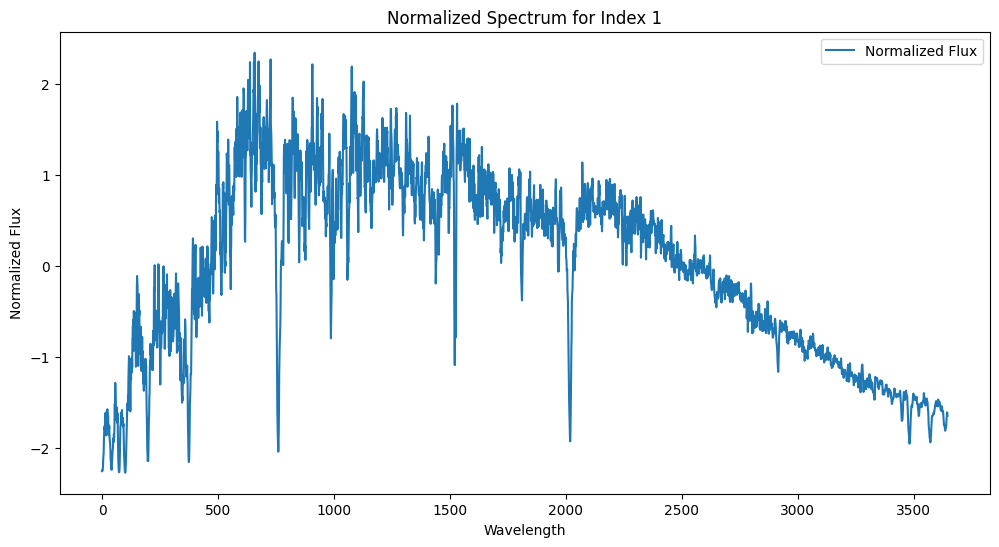

In [87]:
import matplotlib.pyplot as plt

# Plot the normalized spectra
def plot_normalized_spectrum(spectrum_df, index):
    """
    Plots the normalized spectrum for a given index.
    """
    # Extract the flux values for the given index
    flux_values = spectrum_df.iloc[index, :-1].values  # Exclude the last column (file_name)

    # Create a plot
    plt.figure(figsize=(12, 6))
    plt.plot(flux_values, label='Normalized Flux')
    plt.title(f'Normalized Spectrum for Index {index}')
    plt.xlabel('Wavelength')
    plt.ylabel('Normalized Flux')
    plt.legend()
    plt.show()

# Plot the normalized spectrum for the first index
plot_normalized_spectrum(lamost_normalized, 1)

# Normalize Gaia

In [88]:
#---------------------------------------------
# E) Apply Gaia transformations
#---------------------------------------------
print("Applying stored Gaia transformations...")
# Find infinite values in the final DataFrame# find any infinities in the data
def find_infinities(df):
    """
    Finds any infinite values in the DataFrame.
    """
    # Check for infinite values in the DataFrame
    inf_values = df[df == np.inf].sum().sum()

    # Return the sum of infinite values
    return inf_values



gaia_normalized = apply_gaia_transforms(df_gaia, gaia_transformers)


Applying stored Gaia transformations...
Dropped 0 rows with NaN values.
Index(['ra', 'ra_error', 'dec', 'dec_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error', 'flagnopllx', 'flagnoflux'],
      dtype='object')
dict_keys(['parallax', 'ra', 'dec', 'ra_error', 'dec_error', 'parallax_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 'phot_g_mean_flux', 'flagnopllx', 'phot_g_mean_flux_error', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_flux_error', 'flagnoflux'])
Index(['ra', 'ra_error', 'dec', 'dec_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error',

In [89]:
# Print the distribution of each column in the gaia final dataframe
def plot_column_distribution(df):
    """
    Plots the distribution of each column in the DataFrame.
    """
    # Get the number of columns in the DataFrame
    num_cols = len(df.columns)

    # Create a grid of subplots
    fig, axes = plt.subplots(num_cols, 1, figsize=(10, 5*num_cols))

    # Loop through each column and plot the distribution
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {col}')

    plt.tight_layout()
    plt.show()

# Plot the distribution of each column in the final DataFrame
#plot_column_distribution(df_final)


# Generate Predictions

In [90]:
# Merge these spectral features back with matched Gaia rows
# key is given by gaia_lamost_match dataframe which contains source_id and obsid

# Open gaia_lamost_match pickle file
gaia_lamost_match = pd.read_pickle("gaia_lamost_matchv1.pkl")

# Add the source_id column to the LAMOST DataFrame based on the obsid match given by gaia_lamost_match
lamost_normalized2 = lamost_normalized.copy()

# Find the index of the lamost row that matches the obsid in gaia_lamost_match
lamost_normalized2['obsid'] = lamost_normalized2['obsid'].astype(int)
gaia_lamost_match['obsid'] = gaia_lamost_match['obsid'].astype(int)
for index, row in gaia_lamost_match.iterrows():
    obsid = row['obsid']
    source_id = row['source_id']
    lamost_normalized2.loc[lamost_normalized2['obsid'] == obsid, 'source_id'] = source_id

print(lamost_normalized2['source_id'])

# Merge the Gaia and LAMOST dataframes on the 'source_id' column
lamost_normalized2['source_id'] = gaia_lamost_match['source_id']

# Merge the Gaia and LAMOST dataframes on the 'source_id' column
gaia_lamost_merged = pd.merge(gaia_normalized, lamost_normalized2, left_on='source_id', right_on='source_id', how='inner')

print(f"Shape of the merged DataFrame: {gaia_lamost_merged.shape}")
print(gaia_lamost_merged.columns)

0        3.413198e+18
1        3.413117e+18
2        3.413010e+18
3        1.532097e+17
4        3.419541e+18
             ...     
30916    3.413279e+18
30917    3.412249e+18
30918    3.419487e+18
30919    1.465143e+17
30920    3.419893e+18
Name: source_id, Length: 30921, dtype: float64
Shape of the merged DataFrame: (30921, 3667)
Index(['ra', 'ra_error', 'dec', 'dec_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'parallax', 'parallax_error',
       ...
       'flux_3738', 'flux_3739', 'flux_3740', 'flux_3741', 'flux_3742',
       'flux_3743', 'flux_3744', 'flux_3745', 'flux_3746', 'obsid'],
      dtype='object', length=3667)


In [91]:
# save the merged dataframe
gaia_lamost_merged.to_pickle("Pickles/gaia_lamost_merged_example_ind_objects.pkl")

# Generate Predictions


In [92]:
def process_star_data_fusion(
    model_path, 
    data_path, 
    classes_path, 
    d_model_spectra=1024, 
    d_model_gaia=1024, 
    num_classes=55, 
    input_dim_spectra=3647, 
    input_dim_gaia=18, 
    depth=12, 
    sigmoid_constant=0.5,
    class_to_plot="AllStars***lamost"
):
    """Processes star data using the fused StarClassifierFusion model."""

    # Load the data
    X = pd.read_pickle(data_path)
    classes = pd.read_pickle(classes_path)

    # Load the trained fusion model
    model = StarClassifierFusion(
        d_model_spectra=d_model_spectra,
        d_model_gaia=d_model_gaia,
        num_classes=num_classes,
        input_dim_spectra=input_dim_spectra,
        input_dim_gaia=input_dim_gaia,
        n_layers=depth,
        use_cross_attention=True,  # Change to False for late fusion
        n_cross_attn_heads=8
    )

    # Load the state dictionary
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    # Get multi-hot encoded labels
    #y = X[classes]

    # Define Gaia columns
    gaia_columns = [
        "parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec",
        "pmra_error", "pmdec_error", "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error",
        "phot_bp_mean_flux", "phot_rp_mean_flux", "phot_bp_mean_flux_error", "phot_rp_mean_flux_error",
        "flagnoflux"
    ]

    # Separate Gaia and Spectra features
    X_spectra = X.drop(columns={"obsid","source_id", *gaia_columns})
    X_gaia = X[gaia_columns]

    print(f"X_spectra shape: {X_spectra.shape}")
    print(f"X_gaia shape: {X_gaia.shape}")
    #print(f"y shape: {y.shape}")

    if class_to_plot != "AllStars***lamost":
        # Filter for a specific class
        X_spectra = X_spectra[y[class_to_plot] == 1]
        X_gaia = X_gaia[y[class_to_plot] == 1]
        #y = y[y[class_to_plot] == 1]

        print(f"X_spectra shape after filtering for {class_to_plot}: {X_spectra.shape}")
        print(f"X_gaia shape after filtering for {class_to_plot}: {X_gaia.shape}")
       # print(f"y shape after filtering for {class_to_plot}: {y.shape}")

    # Drop label columns from spectra
    #X_spectra.drop(classes, axis=1, inplace=True)

    # Convert to tensors
    X_spectra = torch.tensor(X_spectra.values, dtype=torch.float32)
    X_gaia = torch.tensor(X_gaia.values, dtype=torch.float32)
    #y = torch.tensor(y.values, dtype=torch.float32)

    # Create DataLoader
    class MultiModalDataset(Dataset):
        def __init__(self, X_spectra, X_gaia):
            self.X_spectra = X_spectra
            self.X_gaia = X_gaia
            #self.y = y

        def __len__(self):
            return len(self.X_spectra)

        def __getitem__(self, idx):
            return self.X_spectra[idx], self.X_gaia[idx]

    dataset = MultiModalDataset(X_spectra, X_gaia)
    loader = DataLoader(dataset, batch_size=128, shuffle=False)

    # Move model to device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()

    all_predicted = []
    all_y = []

    with torch.no_grad():
        for X_spc, X_ga in loader:
            # Move data to device
            X_spc, X_ga = X_spc.to(device), X_ga.to(device)

            # Forward pass
            outputs = model(X_spc, X_ga)
            predicted = (torch.sigmoid(outputs) > sigmoid_constant).float()

            # Store predictions and labels
            all_predicted.append(predicted.cpu().numpy())
            #all_y.append(y_batch.cpu().numpy())

            # Free GPU memory
            torch.cuda.empty_cache()

    # Concatenate all predictions and labels
    #y_cpu = np.concatenate(all_y, axis=0)
    predicted_cpu = np.concatenate(all_predicted, axis=0)

    return predicted_cpu

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score

def calculate_precision_per_class(true_labels, predicted_labels):
    """
    Calculates the precision for each class.
    """
    precisions = []
    for i in range(true_labels.shape[1]):
        true_positives = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 1))
        false_positives = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 1))

        if true_positives + false_positives == 0:
            precision = 0  # Avoid division by zero
        else:
            precision = true_positives / (true_positives + false_positives)

        precisions.append(precision)
    return precisions

def calculate_f1_score_per_class(true_labels, predicted_labels):
    """Calculate the F1 score for each class."""
    f1_scores = []
    for i in range(true_labels.shape[1]):
        f1 = f1_score(true_labels[:, i], predicted_labels[:, i])
        f1_scores.append(f1)
    return f1_scores

def calculate_recall_per_class(true_labels, predicted_labels):
    """Calculate the Recall score for each class."""
    recalls = []
    for i in range(true_labels.shape[1]):
        recall = recall_score(true_labels[:, i], predicted_labels[:, i])
        recalls.append(recall)
    return recalls

def calculate_sample_size_per_class(true_labels):
    """Calculates the sample size for each class."""
    return np.sum(true_labels, axis=0)

def plot_metrics_per_class(true_labels, predicted_labels, class_names, log_scale=False, title="Sample Size vs Performance Metrics per Class"):
    """
    Plots precision, recall, and F1 score against sample size for each class.
    """
    sample_sizes = calculate_sample_size_per_class(true_labels)
    precisions = calculate_precision_per_class(true_labels, predicted_labels)
    f1_scores = calculate_f1_score_per_class(true_labels, predicted_labels)
    recalls = calculate_recall_per_class(true_labels, predicted_labels)

    #if log_scale:
        #sample_sizes = np.log10(sample_sizes + 1)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Set Title
    fig.suptitle(title, fontsize=20)

    # Precision plot
    axes[0].scatter(sample_sizes, precisions, color='steelblue', s=100, edgecolors='k', alpha=0.7)
    for i, class_name in enumerate(class_names):
        axes[0].text(sample_sizes[i], precisions[i], class_name, fontsize=9, ha='right')
    
    if log_scale:
        axes[0].set_xscale('log')
        axes[0].set_xlabel('Log10 Sample Size (Total Number of Samples)')
        axes[0].grid(True, which='major', linestyle='--', alpha=0.8)
        axes[0].grid(True, which='minor', linestyle=':', alpha=0.4)
    else:
        axes[0].set_xlabel('Sample Size (Total Number of Samples)')
        axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[0].set_ylabel('Precision (TP / (TP + FP))')
    axes[0].set_xlim(0, np.max(sample_sizes) * 1.05)
    axes[0].set_ylim(-0.0, 1.0)
    axes[0].set_title("Sample Size vs Precision")

    # Recall plot
    axes[1].scatter(sample_sizes, recalls, color='darkorange', s=100, edgecolors='k', alpha=0.7)
    for i, class_name in enumerate(class_names):
        axes[1].text(sample_sizes[i], recalls[i], class_name, fontsize=9, ha='right')

    if log_scale:
        axes[1].set_xscale('log')
        axes[1].set_xlabel('Log10 Sample Size (Total Number of Samples)')
        axes[1].grid(True, which='major', linestyle='--', alpha=0.8)
        axes[1].grid(True, which='minor', linestyle=':', alpha=0.4)
    else:
        axes[1].set_xlabel('Sample Size (Total Number of Samples)')
        axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].set_ylabel('Recall (TP / (TP + FN))')
    axes[1].set_xlim(0, np.max(sample_sizes) * 1.05)
    axes[1].set_ylim(-0.0, 1.0)
    axes[1].set_title("Sample Size vs Recall")

    # F1 Score plot
    axes[2].scatter(sample_sizes, f1_scores, color='forestgreen', s=100, edgecolors='k', alpha=0.7)
    for i, class_name in enumerate(class_names):
        axes[2].text(sample_sizes[i], f1_scores[i], class_name, fontsize=9, ha='right')

    if log_scale:
        axes[2].set_xscale('log')
        axes[2].set_xlabel('Log10 Sample Size (Total Number of Samples)')
        axes[2].grid(True, which='major', linestyle='--', alpha=0.8)
        axes[2].grid(True, which='minor', linestyle=':', alpha=0.4)
    else:
        axes[2].set_xlabel('Sample Size (Total Number of Samples)')
        axes[2].grid(True, linestyle='--', alpha=0.6)
    axes[2].set_ylabel('F1 Score (2 * Precision * Recall / (Precision + Recall))')
    axes[2].set_xlim(0, np.max(sample_sizes) * 1.05)
    axes[2].set_ylim(-0.0, 1.0)
    axes[2].set_title("Sample Size vs F1 Score")

    plt.tight_layout()
    plt.show()

In [94]:
# Example usage
model_path = "Models/model_fusion_mamba_v2.pth"
data_path = "Pickles/gaia_lamost_merged_example_ind_objects.pkl"
classes_path = "Pickles/Updated_list_of_Classes.pkl"

# Normal Mode
predicted_cpu = process_star_data_fusion(model_path, data_path, classes_path, sigmoid_constant=0.5)

# Save the predictions
#np.save("mamba_fused_v2_y_cpu.npy", y_cpu)
np.save("example_eclipsing_bin_y_pred_cpu.npy", predicted_cpu)
print(predicted_cpu)



C:\Users\jcwin\AppData\Local\Temp\ipykernel_24916\3857443517.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


X_spectra shape: (30921, 3647)
X_gaia shape: (30921, 18)
[[0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]]


In [95]:
# Load the predictions and classes for plotting
#y_cpu = np.load("mamba_fused_v2_y_cpu.npy")
y_pred_cpu = np.load("example_eclipsing_bin_y_pred_cpu.npy")
classes = pd.read_pickle("Pickles/Updated_list_of_Classes.pkl")

print(classes)

# Generate the y_true for the class to plot, they are the same for all classes "**" and "EB*" columns are 1 the rest is 0
y_true = np.zeros_like(y_pred_cpu)
y_true[:, -1] = 1 # EB* column
y_true[:, 1] = 1 # ** column


['RS*', '**', 'El*', 'Y*O', 's*b', 'cC*', 'HB*', 'dS*', 'Or*', 'LP*', 'BS*', 'Ae*', 'WV*', 'HS*', 'Ev*', 'AB*', 'sg*', 's*r', 'Ce*', 'gD*', 'OH*', 'HXB', 'Pu*', 'RV*', 'Sy*', 'V*', 'TT*', 'SN*', 'Be*', 'SB*', 'Em*', 'Er*', 'PM*', 'HV*', 'pA*', 'C*', 'BY*', 'Ro*', 'XB*', 'Ma*', 'Pe*', 'CV*', 'bC*', 'RR*', 'Mi*', 'SX*', 'RG*', 'LM*', 'WD*', 'S*', 'MS*', 'Ir*', 'a2*', 'PN', 'EB*']


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification

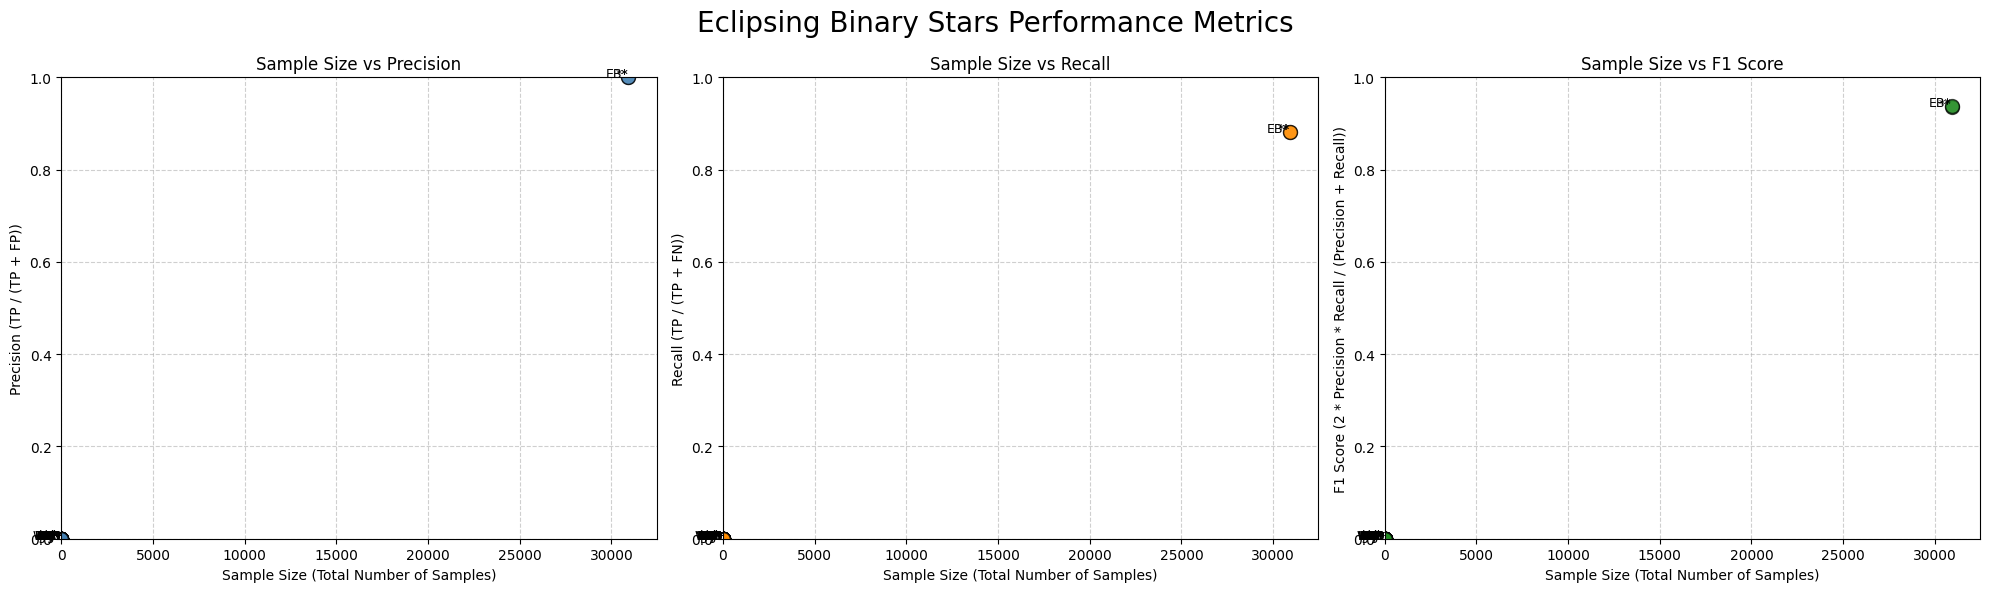

In [98]:
plot_metrics_per_class(y_true, predicted_cpu, classes, log_scale=False, title="Eclipsing Binary Stars Performance Metrics")  

In [99]:
# print the precision, recall and f1 score for ** and EB* classes
print(f"Precision for ** class: {calculate_precision_per_class(y_true, predicted_cpu)[1]}")
print(f"Recall for ** class: {calculate_recall_per_class(y_true, predicted_cpu)[1]}")
print(f"F1 Score for ** class: {calculate_f1_score_per_class(y_true, predicted_cpu)[1]}")
print(f"Precision for EB* class: {calculate_precision_per_class(y_true, predicted_cpu)[-1]}")
print(f"Recall for EB* class: {calculate_recall_per_class(y_true, predicted_cpu)[-1]}")
print(f"F1 Score for EB* class: {calculate_f1_score_per_class(y_true, predicted_cpu)[-1]}")

Precision for ** class: 1.0


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarni

Recall for ** class: 0.8806312861809127


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification

F1 Score for ** class: 0.9365273168131244
Precision for EB* class: 1.0


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarni

Recall for EB* class: 0.8816338410788784


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification

F1 Score for EB* class: 0.937093946581417


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification

In [97]:
#---------------------------------------------
# F) Generate Predictions from Multi-Label Classifier
#---------------------------------------------
#  1) Extract just the columns your model expects as `X_infer`.
#     This must match the training feature order exactly.
#     (You might load the “train_data_transformed.pkl” columns 
#      to see the final column order used in training.)
#
#     For example, let’s suppose:
#     train_cols = [...]
#
#     Then do:
#          X_infer = df_final[train_cols].values
#
#  2) Call the classifier’s predict_proba(...) or decision_function(...).
#     Because it’s a multi-label classifier with a sigmoid output,
#     you typically get probabilities for each label.
#
#  3) Combine results into a DataFrame for convenience.
#

# Example (adjust column order to match your training):
# Suppose these columns (not including the label columns themselves):
example_train_cols = [
    "parallax","pmra","pmdec","phot_g_mean_flux","phot_bp_mean_flux",
    # ... all other columns your model expects ...
    "spec_feat_1","spec_feat_2","spec_feat_3",  # from LAMOST pipeline
    # ...
]
# Make sure they exist in df_final:
X_infer = df_final[example_train_cols].values

print("Predicting multi-label probabilities...")
y_proba = multi_label_clf.predict_proba(X_infer)  # shape: (N, number_of_labels)

# Combine into a nice DataFrame:
df_results = pd.DataFrame(y_proba, columns=final_label_cols)
# Optional thresholding if you want binary predictions:
# e.g. 
# df_pred = (df_results >= 0.5).astype(int)

#---------------------------------------------
# G) Attach object IDs for clarity
#---------------------------------------------
df_results["source_id"] = df_final["source_id"].values
df_results["obsid"]     = df_final["obsid"].values

NameError: name 'df_final' is not defined

In [ ]:
#---------------------------------------------
# D) Process the LAMOST spectra => final spectral features
#---------------------------------------------
print("Processing LAMOST spectra into final feature set...")
df_spectra = process_lamost_spectra(spectra_)
# `df_spectra` should have columns [obsid, spec_feat_1, spec_feat_2, ...]

# Merge these spectral features back with matched Gaia rows
# by 'obsid' (or whichever key you use).
df_all = pd.merge(df_matched, df_spectra, on="obsid", how="inner")

In [39]:

# Rename the 'file_name' column to 'obsid' for merging
df_normalized['obsid'] = df_normalized['file_name'].astype(int)

# print the head of the normalized dataframe and the original dataframe
print(df_normalized.head())
print(df_gaia.head())

# join the two dataframes
df_final = pd.merge(df_gaia, df_normalized, on='obsid', how='inner')

   flux_100  flux_101  flux_102  flux_103  flux_104  flux_105  flux_106  \
0  0.356662 -0.542015  0.343776 -0.628688 -0.266687 -0.063425  0.388014   
1 -0.035140  0.310879 -0.119607  0.347709  1.611782  1.738124  1.852735   
2 -2.514002 -2.562955 -2.480771 -2.554936 -2.567870 -2.567537 -2.569813   
3 -2.191129 -2.184766 -2.189639 -2.193250 -2.191432 -2.193878 -2.160701   
4 -4.477099 -4.610079 -3.941276 -4.400664 -3.935617 -3.627640 -2.431933   

   flux_107  flux_108  flux_109  ...  flux_3739  flux_3740  flux_3741  \
0  0.590173  0.050844  0.675847  ...  -1.647424  -1.627925  -1.626825   
1  0.994927  1.407971  1.111360  ...  -1.701933  -1.763633  -1.597296   
2 -2.501395 -2.448351 -2.251959  ...  -1.091336  -1.100993  -1.104104   
3 -2.157340 -2.143519 -2.123984  ...  -1.075534  -1.127951  -1.117674   
4 -2.108811 -2.561642 -2.655316  ...  -1.440890  -1.469102  -1.492443   

   flux_3742  flux_3743  flux_3744  flux_3745  flux_3746    file_name  \
0  -1.623360  -1.616637  -1.605371  -

KeyError: 'obsid'

In [ ]:
# Example usage:
# gaia_ids = [12345, 67890, ...]
# Run for the top 100 Gaia IDs
results = run_inference(df[:20], lamost_catalog)

Querying Gaia for your object list...


KeyboardInterrupt: 